# Step 6: Post-Scoring Packaging (Enhanced)
Backup results, generate reports, produce scored PDFs, and collect samples for sharing. Run after completing scoring and checks.

**Enhanced Features:**
- ✅ Comprehensive backup and archiving system
- ✅ Enhanced report generation with detailed analytics
- ✅ Automated PDF processing with validation
- ✅ Performance report generation with AI insights
- ✅ Class-level analytics and recommendations
- ✅ Robust error handling and progress tracking

In [1]:
from grading_utils import setup_paths, create_directories, build_student_id_mapping
import os
import json
import pandas as pd
import shutil
import time
from datetime import datetime
from pathlib import Path
from PIL import Image
import cv2
from IPython.display import display, clear_output
from ipywidgets import IntProgress, HTML
import logging
from pypdf import PdfReader, PdfWriter
import re
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib
import math
from docx import Document
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.shared import Pt, Inches


# Enhanced logging setup
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

print("✅ Enhanced Step 6: Post-Scoring Packaging initialized")
print(f"✓ Session started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Configuration
passingMark = 15  # Adjust as needed
prefix = "VTC Test"
paths = setup_paths(prefix, "sample")

# Extract commonly used paths
pdf_file = paths["pdf_file"]
name_list_file = paths["name_list_file"]
base_path = paths["base_path"]
base_path_images = paths["base_path_images"]
base_path_annotations = paths["base_path_annotations"]
base_path_questions = paths["base_path_questions"]
base_path_marked_images = paths["base_path_marked_images"]
base_path_marked_pdfs = paths["base_path_marked_pdfs"]
base_path_marked_scripts = paths["base_path_marked_scripts"]
cache_dir = paths.get("cache_dir", "cache")

# Create all necessary directories
create_directories(paths)

print("✓ Paths configured and directories created")

# Metadata questions that should be excluded from answer analysis
METADATA_QUESTIONS = ["NAME", "ID", "CLASS"]

print("💡 Metadata questions (NAME, ID, CLASS) will be excluded from answer analysis")

✅ Enhanced Step 6: Post-Scoring Packaging initialized
✓ Session started at: 2026-01-04 23:02:53
✓ Paths configured and directories created
💡 Metadata questions (NAME, ID, CLASS) will be excluded from answer analysis


In [2]:
# Enhanced backup and cleanup with validation
def enhanced_backup_and_cleanup():
    """Enhanced backup with comprehensive validation and error handling"""
    print("🧹 Performing enhanced backup and cleanup...")
    
    try:
        # Remove version history files with progress tracking
        version_files_removed = 0
        for path, currentDirectory, files in os.walk(base_path_questions):
            for file in files:
                if file.startswith("control-") or file.startswith("mark-"):
                    try:
                        os.remove(os.path.join(path, file))
                        version_files_removed += 1
                    except Exception as e:
                        logger.warning(f"Failed to remove {file}: {e}")
        
        logger.info(f"✓ Removed {version_files_removed} version history files")
        
        # Create backup archive with validation
        backup_path = shutil.make_archive(base_path, "zip", base_path)
        
        if os.path.exists(backup_path):
            backup_size = os.path.getsize(backup_path)
            logger.info(f"✓ Created backup archive: {backup_path}")
            logger.info(f"  Archive size: {backup_size:,} bytes ({backup_size/1024/1024:.1f} MB)")
            return backup_path
        else:
            raise Exception("Failed to create backup archive")
            
    except Exception as e:
        logger.error(f"❌ Backup and cleanup failed: {e}")
        raise

# Perform backup and cleanup
backup_path = enhanced_backup_and_cleanup()

# Perform backup and cleanup
backup_path = enhanced_backup_and_cleanup()

2026-01-04 23:02:53,114 - INFO - ✓ Removed 0 version history files
2026-01-04 23:02:53,207 - INFO - ✓ Created backup archive: /home/developer/Documents/data-disk/gemini-handwriting-grader/marking_form/VTC Test.zip
2026-01-04 23:02:53,207 - INFO -   Archive size: 3,599,395 bytes (3.4 MB)
2026-01-04 23:02:53,208 - INFO - ✓ Removed 0 version history files
2026-01-04 23:02:53,300 - INFO - ✓ Created backup archive: /home/developer/Documents/data-disk/gemini-handwriting-grader/marking_form/VTC Test.zip
2026-01-04 23:02:53,301 - INFO -   Archive size: 3,599,395 bytes (3.4 MB)


🧹 Performing enhanced backup and cleanup...
🧹 Performing enhanced backup and cleanup...


In [3]:
# Enhanced score report generation with comprehensive validation
def generate_enhanced_score_report():
    """Generate comprehensive score report with enhanced validation and analytics"""
    print("📊 Generating enhanced score report...")
    
    try:
        # Load name list as authoritative source for student names
        name_list_df = pd.read_excel(name_list_file, sheet_name="Name List")
        
        # Validate name list structure
        id_col = next((col for col in name_list_df.columns if col.lower() == "id"), None)
        name_col = next((col for col in name_list_df.columns if col.lower() in ["name", "student name", "student_name"]), None)
        
        if id_col is None or name_col is None:
            raise ValueError("Name list must contain ID and NAME columns.")
        
        name_map = (
            name_list_df.assign(**{id_col: name_list_df[id_col].astype(str)})
            .set_index(id_col)[name_col]
            .astype(str)
            .to_dict()
        )
        
        logger.info(f"✓ Loaded {len(name_map)} student names from name list")
        
        # Build student ID mapping using utility function
        pageToStudentId, numberOfPage, getStudentId = build_student_id_mapping(
            base_path_questions, base_path_annotations
        )
        
        logger.info(f"✓ Built student ID mapping for {numberOfPage} pages")
        
        # Extract marks from all questions
        questionAndMarks = {}
        questions_processed = 0
        
        for path, currentDirectory, files in os.walk(base_path_questions):
            for file in files:
                if file == "mark.json":
                    question = path[len(base_path_questions) + 1 :]
                    
                    try:
                        with open(os.path.join(path, file), 'r', encoding='utf-8') as f:
                            data = json.load(f)
                        
                        marks = {}
                        for i in data:
                            studentId = getStudentId(int(i["id"]))
                            marks[studentId] = (
                                i["overridedMark"] if i["overridedMark"] != "" else i["mark"]
                            )
                        
                        questionAndMarks[question] = marks
                        questions_processed += 1
                        logger.info(f"✓ Processed marks for {question}: {len(marks)} students")
                        
                    except Exception as e:
                        logger.error(f"❌ Failed to process marks for {question}: {e}")
                        continue
        
        logger.info(f"✓ Processed marks from {questions_processed} questions")
        
        # Create marks DataFrame with enhanced validation
        marksDf = pd.DataFrame(questionAndMarks)
        
        # Reorder columns: ID, NAME, CLASS first, then questions in sorted order
        marksDf = marksDf[
            ["ID", "NAME", "CLASS"]
            + [
                col
                for col in sorted(marksDf.columns)
                if col not in ["ID", "NAME", "CLASS"]
            ]
        ]
        
        # Prefer names from the uploaded name list, fallback to marked value when missing
        marksDf["ID"] = marksDf["ID"].astype(str)
        marksDf["NAME"] = marksDf["ID"].map(name_map).fillna(marksDf["NAME"])
        
        # Calculate total marks with validation
        numeric_columns = marksDf.loc[:, ~marksDf.columns.isin(["ID", "NAME", "CLASS"])]
        marksDf["Marks"] = numeric_columns.apply(pd.to_numeric, errors='coerce').sum(axis=1)
        
        # Validate marks calculation
        invalid_marks = marksDf[marksDf["Marks"].isna()]
        if not invalid_marks.empty:
            logger.warning(f"Found {len(invalid_marks)} students with invalid marks")
        
        logger.info(f"✓ Generated marks report for {len(marksDf)} students")
        logger.info(f"  Average score: {marksDf['Marks'].mean():.2f}")
        logger.info(f"  Score range: {marksDf['Marks'].min():.1f} - {marksDf['Marks'].max():.1f}")
        
        return marksDf
        
    except Exception as e:
        logger.error(f"❌ Score report generation failed: {e}")
        raise

# Generate enhanced score report
marksDf = generate_enhanced_score_report()
display(marksDf)

2026-01-04 23:02:53,360 - INFO - ✓ Loaded 4 student names from name list
2026-01-04 23:02:53,361 - INFO - ✓ Built student ID mapping for 2 pages
2026-01-04 23:02:53,362 - INFO - ✓ Processed marks for Q1: 4 students
2026-01-04 23:02:53,363 - INFO - ✓ Processed marks for Q4: 4 students
2026-01-04 23:02:53,364 - INFO - ✓ Processed marks for CLASS: 4 students
2026-01-04 23:02:53,365 - INFO - ✓ Processed marks for Q2: 4 students
2026-01-04 23:02:53,365 - INFO - ✓ Processed marks for Q3: 4 students
2026-01-04 23:02:53,366 - INFO - ✓ Processed marks for Q5: 4 students
2026-01-04 23:02:53,366 - INFO - ✓ Processed marks for NAME: 4 students
2026-01-04 23:02:53,366 - INFO - ✓ Processed marks for ID: 4 students
2026-01-04 23:02:53,367 - INFO - ✓ Processed marks from 8 questions
2026-01-04 23:02:53,370 - INFO - ✓ Generated marks report for 4 students
2026-01-04 23:02:53,372 - INFO -   Average score: 14.75
2026-01-04 23:02:53,372 - INFO -   Score range: 11.0 - 24.0


📊 Generating enhanced score report...


,ID,NAME,CLASS,Q1,Q2,Q3,Q4,Q5,Marks
123456789,123456789,Peter,A,2.0,10.0,1.0,8.0,3.0,24.0
345678912,345678912,Susan,D,2.0,10.0,0.0,0.0,0.0,12.0
987654321,987654321,Mary,B,1.0,10.0,0.0,0.0,0.0,11.0
234567890,234567890,John,C,2.0,1.0,3.0,0.0,6.0,12.0


In [4]:
# Enhanced scored scripts creation with comprehensive validation
def create_enhanced_scored_scripts():
    """Create scored scripts with enhanced validation and error handling"""
    print("📄 Creating enhanced scored scripts...")
    
    try:
        # Copy raw images to marked folder with validation
        if os.path.exists(base_path_marked_images):
            shutil.rmtree(base_path_marked_images)
        
        copied_path = shutil.copytree(base_path_images, base_path_marked_images)
        
        # Validate copy operation
        original_files = len([f for f in os.listdir(base_path_images) if f.endswith('.jpg')])
        copied_files = len([f for f in os.listdir(base_path_marked_images) if f.endswith('.jpg')])
        
        if original_files != copied_files:
            raise Exception(f"Image copy validation failed: {original_files} original vs {copied_files} copied")
        
        logger.info(f"✓ Copied {copied_files} images to marked folder")
        
        # Load and validate annotations
        annotations_path = base_path_annotations + "annotations.json"
        with open(annotations_path, "r") as f: 
            annotations = json.load(f)
        
        # Flatten annotations to list with enhanced validation
        annotations_list = []
        for page in annotations:
            for annotation in annotations[page]:
                annotation["page"] = int(page)
                # x to left, y to top
                annotation["left"] = annotation["x"]
                annotation["top"] = annotation["y"]
                annotation.pop("x")
                annotation.pop("y")
                annotations_list.append(annotation)
        
        # Convert annotations_list to dict with key with label
        annotations_dict = {}
        for annotation in annotations_list:
            annotations_dict[annotation["label"]] = annotation
        
        logger.info(f"✓ Processed {len(annotations_dict)} annotations")
        
        # Build student ID to page mapping
        studentIdToPage = {}
        with open(os.path.join(base_path_questions, "ID", "mark.json")) as f:
            data = json.load(f)
            for i in data:
                studentId = i["overridedMark"] if i["overridedMark"] != "" else i["mark"]
                studentIdToPage[studentId] = int(i["id"])
        
        logger.info(f"✓ Built student-to-page mapping for {len(studentIdToPage)} students")
        
        # Add marks to images with progress tracking
        marksDf_list = marksDf.to_dict(orient="records")
        
        progress = IntProgress(min=0, max=len(marksDf_list), description='Adding marks')
        display(progress)
        
        processed_students = 0
        failed_students = []
        
        for student in marksDf_list:
            try:
                first_page = studentIdToPage[student["ID"]]
                
                for annotation in annotations_dict:
                    value = student[annotation]
                    if annotation == "ID":
                        value = value + " Marks: " + str(student["Marks"])
                    
                    x = annotations_dict[annotation]["left"]
                    y = annotations_dict[annotation]["top"]
                    page = first_page + annotations_dict[annotation]["page"]
                  
                    image_path = base_path_marked_images + str(page) + ".jpg"
                    
                    if not os.path.exists(image_path):
                        logger.warning(f"Image not found: {image_path}")
                        continue
                    
                    # Add text to image with error handling
                    try:
                        img = cv2.imread(image_path)
                        if img is None:
                            logger.warning(f"Failed to load image: {image_path}")
                            continue
                        
                        textSize = cv2.getTextSize(text=str(value), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, thickness=2)
                        height = textSize[0][1]
                        cv2.putText(img, str(value), (x, y + height), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                        cv2.imwrite(image_path, img)
                        
                    except Exception as e:
                        logger.warning(f"Failed to add text to {image_path}: {e}")
                        continue
                
                processed_students += 1
                
            except Exception as e:
                logger.error(f"Failed to process student {student['ID']}: {e}")
                failed_students.append(student['ID'])
            
            progress.value += 1
        
        logger.info(f"✓ Added marks to images for {processed_students} students")
        if failed_students:
            logger.warning(f"Failed to process {len(failed_students)} students: {failed_students}")
        
        return studentIdToPage, processed_students, failed_students
        
    except Exception as e:
        logger.error(f"❌ Scored scripts creation failed: {e}")
        raise

# Create enhanced scored scripts
studentIdToPage, processed_students, failed_students = create_enhanced_scored_scripts()

# Create enhanced scored scripts
studentIdToPage, processed_students, failed_students = create_enhanced_scored_scripts()

2026-01-04 23:02:53,412 - INFO - ✓ Copied 8 images to marked folder
2026-01-04 23:02:53,413 - INFO - ✓ Processed 8 annotations
2026-01-04 23:02:53,414 - INFO - ✓ Built student-to-page mapping for 4 students


📄 Creating enhanced scored scripts...


IntProgress(value=0, description='Adding marks', max=4)

2026-01-04 23:02:53,778 - INFO - ✓ Added marks to images for 4 students
2026-01-04 23:02:53,781 - INFO - ✓ Copied 8 images to marked folder
2026-01-04 23:02:53,782 - INFO - ✓ Processed 8 annotations
2026-01-04 23:02:53,783 - INFO - ✓ Built student-to-page mapping for 4 students


📄 Creating enhanced scored scripts...


IntProgress(value=0, description='Adding marks', max=4)

2026-01-04 23:02:54,104 - INFO - ✓ Added marks to images for 4 students


In [5]:
# Enhanced PDF generation with comprehensive validation
def generate_enhanced_pdfs(studentIdToPage, numberOfPage):
    """Generate individual PDFs with enhanced validation and error handling"""
    print("📄 Generating enhanced individual PDFs...")
    
    try:
        marksDf_list = marksDf.to_dict(orient="records")
        
        pdf_generation_stats = {
            'successful': 0,
            'failed': 0,
            'errors': []
        }
        
        for student in marksDf_list:
            try:
                studentId = student["ID"]
                first_page = studentIdToPage[student["ID"]]
                last_page = first_page + numberOfPage - 1
                
                logger.info(f"Processing PDF for {studentId}: pages {first_page}-{last_page}")
                
                pdf_path = base_path_marked_pdfs + studentId + ".pdf"
                
                # Validate all required images exist
                image_paths = [base_path_marked_images + str(i) + ".jpg" for i in range(first_page, last_page + 1)]
                missing_images = [path for path in image_paths if not os.path.exists(path)]
                
                if missing_images:
                    error_msg = f"Missing images for {studentId}: {missing_images}"
                    logger.error(error_msg)
                    pdf_generation_stats['errors'].append(error_msg)
                    pdf_generation_stats['failed'] += 1
                    continue
                
                # Load and validate images
                try:
                    images = []
                    for path in image_paths:
                        img = Image.open(path)
                        if img.mode != 'RGB':
                            img = img.convert('RGB')
                        images.append(img)
                    
                    # Create PDF with validation
                    if images:
                        images[0].save(pdf_path, save_all=True, append_images=images[1:] if len(images) > 1 else [])
                        
                        # Validate PDF creation
                        if os.path.exists(pdf_path) and os.path.getsize(pdf_path) > 0:
                            pdf_generation_stats['successful'] += 1
                            logger.info(f"✓ Created PDF for {studentId}: {os.path.getsize(pdf_path)} bytes")
                        else:
                            error_msg = f"PDF creation failed for {studentId}: file not created or empty"
                            logger.error(error_msg)
                            pdf_generation_stats['errors'].append(error_msg)
                            pdf_generation_stats['failed'] += 1
                    else:
                        error_msg = f"No images loaded for {studentId}"
                        logger.error(error_msg)
                        pdf_generation_stats['errors'].append(error_msg)
                        pdf_generation_stats['failed'] += 1
                        
                except Exception as e:
                    error_msg = f"Image processing failed for {studentId}: {e}"
                    logger.error(error_msg)
                    pdf_generation_stats['errors'].append(error_msg)
                    pdf_generation_stats['failed'] += 1
                    
            except Exception as e:
                error_msg = f"PDF generation failed for {studentId}: {e}"
                logger.error(error_msg)
                pdf_generation_stats['errors'].append(error_msg)
                pdf_generation_stats['failed'] += 1
        
        # Display generation summary
        print(f"\n📊 PDF Generation Summary:")
        print(f"   Successful: {pdf_generation_stats['successful']}")
        print(f"   Failed: {pdf_generation_stats['failed']}")
        print(f"   Success rate: {pdf_generation_stats['successful']/(pdf_generation_stats['successful']+pdf_generation_stats['failed'])*100:.1f}%")
        
        if pdf_generation_stats['errors']:
            print(f"\n❌ Errors encountered:")
            for error in pdf_generation_stats['errors'][:5]:  # Show first 5 errors
                print(f"   • {error}")
            if len(pdf_generation_stats['errors']) > 5:
                print(f"   ... and {len(pdf_generation_stats['errors'])-5} more errors")
        
        return pdf_generation_stats
        
    except Exception as e:
        logger.error(f"❌ PDF generation failed: {e}")
        raise

# Generate enhanced PDFs
# Get numberOfPage from the student ID mapping
pageToStudentId, numberOfPage, getStudentId = build_student_id_mapping(
    base_path_questions, base_path_annotations
)

pdf_stats = generate_enhanced_pdfs(studentIdToPage, numberOfPage)

# Generate enhanced PDFs
# Get numberOfPage from the student ID mapping
pageToStudentId, numberOfPage, getStudentId = build_student_id_mapping(
    base_path_questions, base_path_annotations
)

pdf_stats = generate_enhanced_pdfs(studentIdToPage, numberOfPage)

2026-01-04 23:02:54,123 - INFO - Processing PDF for 123456789: pages 0-1
2026-01-04 23:02:54,170 - INFO - ✓ Created PDF for 123456789: 253945 bytes
2026-01-04 23:02:54,171 - INFO - Processing PDF for 345678912: pages 6-7
2026-01-04 23:02:54,203 - INFO - ✓ Created PDF for 345678912: 244590 bytes
2026-01-04 23:02:54,208 - INFO - Processing PDF for 987654321: pages 2-3
2026-01-04 23:02:54,248 - INFO - ✓ Created PDF for 987654321: 235774 bytes
2026-01-04 23:02:54,249 - INFO - Processing PDF for 234567890: pages 4-5
2026-01-04 23:02:54,275 - INFO - ✓ Created PDF for 234567890: 249430 bytes
2026-01-04 23:02:54,276 - INFO - Processing PDF for 123456789: pages 0-1
2026-01-04 23:02:54,303 - INFO - ✓ Created PDF for 123456789: 253945 bytes
2026-01-04 23:02:54,303 - INFO - Processing PDF for 345678912: pages 6-7


📄 Generating enhanced individual PDFs...

📊 PDF Generation Summary:
   Successful: 4
   Failed: 0
   Success rate: 100.0%
📄 Generating enhanced individual PDFs...


2026-01-04 23:02:54,329 - INFO - ✓ Created PDF for 345678912: 244590 bytes
2026-01-04 23:02:54,329 - INFO - Processing PDF for 987654321: pages 2-3
2026-01-04 23:02:54,355 - INFO - ✓ Created PDF for 987654321: 235774 bytes
2026-01-04 23:02:54,356 - INFO - Processing PDF for 234567890: pages 4-5
2026-01-04 23:02:54,382 - INFO - ✓ Created PDF for 234567890: 249430 bytes



📊 PDF Generation Summary:
   Successful: 4
   Failed: 0
   Success rate: 100.0%


In [6]:
# Enhanced sample generation with comprehensive validation
def generate_enhanced_samples():
    """Generate sample PDFs with enhanced validation and error handling"""
    print("📚 Generating enhanced sample collections...")
    
    try:
        # Create combined PDF of all scripts
        writer = PdfWriter()
        
        pdf_files_added = 0
        for path, currentDirectory, files in os.walk(base_path_marked_pdfs):
            for file in files:
                if file.endswith(".pdf"):
                    pdf_path = os.path.join(path, file)
                    try:
                        reader = PdfReader(pdf_path)
                        for page in reader.pages:
                            writer.add_page(page)
                        pdf_files_added += 1
                    except Exception as e:
                        logger.warning(f"Failed to add {pdf_path} to combined PDF: {e}")
        
        combined_path = base_path_marked_scripts + "all.pdf"
        with open(combined_path, "wb") as f:
            writer.write(f)
        
        logger.info(f"✓ Created combined PDF with {pdf_files_added} individual PDFs")
        
        # Generate stratified samples with enhanced validation
        sampling = marksDf.sort_values(by=["Marks"], ascending=False)["Marks"]
        
        from_directory = os.path.join(os.getcwd(), "..", "templates", "pdf")
        
        # Validate template files exist
        template_files = {
            'good': os.path.join(from_directory, "Good.pdf"),
            'average': os.path.join(from_directory, "Average.pdf"),
            'weak': os.path.join(from_directory, "Weak.pdf")
        }
        
        missing_templates = [name for name, path in template_files.items() if not os.path.exists(path)]
        if missing_templates:
            logger.warning(f"Missing template files: {missing_templates}")
            logger.info("Creating sample without templates...")
            return
        
        try:
            goodPage = PdfReader(template_files['good'])
            averagePage = PdfReader(template_files['average'])
            weakPage = PdfReader(template_files['weak'])
        except Exception as e:
            logger.warning(f"Failed to load template files: {e}")
            logger.info("Creating sample without templates...")
            return
        
        def get_scripts_pdf(df):
            return list(map(lambda rowNumber: base_path_marked_pdfs + rowNumber + ".pdf", df.index))
        
        def take_sample_enhanced(n, sampling, suffix=""):
            """Enhanced sample generation with validation"""
            try:
                if len(sampling) < 3 * n:
                    n = max(1, int(len(sampling) / 3))
                    logger.warning(f"Adjusted sample size to {n} due to insufficient data")
                
                good = sampling.head(n)
                weak = sampling.tail(n)
                median = int(len(sampling) / 2)
                take = max(1, int(n / 2))
                average = sampling.iloc[median - take : median + take]
                
                writer = PdfWriter()
                
                # Add template pages and student PDFs with validation
                for page in goodPage.pages:
                    writer.add_page(page)
                
                for pdf in get_scripts_pdf(good):
                    if os.path.exists(pdf):
                        try:
                            reader = PdfReader(pdf)
                            for page in reader.pages:
                                writer.add_page(page)
                        except Exception as e:
                            logger.warning(f"Failed to add {pdf}: {e}")
                
                for page in averagePage.pages:
                    writer.add_page(page)
                
                for pdf in get_scripts_pdf(average):
                    if os.path.exists(pdf):
                        try:
                            reader = PdfReader(pdf)
                            for page in reader.pages:
                                writer.add_page(page)
                        except Exception as e:
                            logger.warning(f"Failed to add {pdf}: {e}")
                
                for page in weakPage.pages:
                    writer.add_page(page)
                
                for pdf in get_scripts_pdf(weak):
                    if os.path.exists(pdf):
                        try:
                            reader = PdfReader(pdf)
                            for page in reader.pages:
                                writer.add_page(page)
                        except Exception as e:
                            logger.warning(f"Failed to add {pdf}: {e}")
                
                fileName = base_path_marked_scripts + "sampleOf" + str(n) + suffix + ".pdf"
                with open(fileName, "wb") as f:
                    writer.write(f)
                
                # Validate sample creation
                if os.path.exists(fileName) and os.path.getsize(fileName) > 0:
                    logger.info(f"✓ Created sample: {fileName} ({os.path.getsize(fileName)} bytes)")
                else:
                    logger.error(f"❌ Failed to create sample: {fileName}")
                    
            except Exception as e:
                logger.error(f"❌ Sample generation failed for n={n}, suffix={suffix}: {e}")
        
        # Generate different sample sizes
        take_sample_enhanced(3, sampling)
        take_sample_enhanced(5, sampling)
        
        # Generate samples for passing students only
        passing_sampling = sampling.where(lambda x: x > passingMark).dropna()
        if len(passing_sampling) >= 3:
            take_sample_enhanced(3, passing_sampling, "_only_pass")
        if len(passing_sampling) >= 5:
            take_sample_enhanced(5, passing_sampling, "_only_pass")
        else:
            logger.warning(f"Insufficient passing students ({len(passing_sampling)}) for passing-only samples")
        
        logger.info("✓ Sample generation completed")
        
    except Exception as e:
        logger.error(f"❌ Sample generation failed: {e}")
        raise

# Generate enhanced samples
generate_enhanced_samples()

2026-01-04 23:02:54,409 - INFO - ✓ Created combined PDF with 4 individual PDFs
2026-01-04 23:02:54,412 - WARNING - Adjusted sample size to 1 due to insufficient data
2026-01-04 23:02:54,418 - INFO - ✓ Created sample: ../marking_form/VTC Test/marked/scripts/sampleOf1.pdf (983962 bytes)
2026-01-04 23:02:54,418 - WARNING - Adjusted sample size to 1 due to insufficient data
2026-01-04 23:02:54,423 - INFO - ✓ Created sample: ../marking_form/VTC Test/marked/scripts/sampleOf1.pdf (983962 bytes)
2026-01-04 23:02:54,424 - WARNING - Insufficient passing students (1) for passing-only samples
2026-01-04 23:02:54,424 - INFO - ✓ Sample generation completed


📚 Generating enhanced sample collections...


In [7]:
# Enhanced answer collection and reasoning with metadata exclusion
import pandas as pd
import re

def clean_answer_text(val: str) -> str:
    """Strip leading numbering and drop standalone question labels like Q2."""
    if not isinstance(val, str):
        return val
    lines = [ln.strip() for ln in str(val).splitlines()]
    cleaned = []
    for ln in lines:
        ln = re.sub(r"^\s*\d+\s*[\.|\)]\s*", "", ln)
        if re.fullmatch(r"q\d+", ln, flags=re.IGNORECASE):
            continue
        if ln:
            cleaned.append(ln)
    return "\n".join(cleaned).strip()

def collect_answers_and_reasoning():
    """Gather per-student answers and model reasoning from each question's CSV and pivot to a mark-style wide format."""
    print("📝 Collecting answers and reasoning from question data...")
    
    answer_rows = []
    reasoning_rows = []
    questions_processed = 0

    for path, currentDirectory, files in os.walk(base_path_questions):
        if "data.csv" not in files:
            continue

        question = path[len(base_path_questions) + 1 :]
        
        # Skip metadata questions (NAME, ID, CLASS)
        if question in METADATA_QUESTIONS:
            logger.info(f"⏭️ Skipping metadata question: {question}")
            continue
            
        data_path = os.path.join(path, "data.csv")
        
        try:
            df = pd.read_csv(data_path)
            if "page" not in df.columns:
                logger.warning(f"No 'page' column in {question} data.csv")
                continue

            # Map scanned page back to student ID using the existing helper
            df["StudentID"] = df["page"].apply(
                lambda p: getStudentId(int(str(p).split(".")[0])) if pd.notna(p) else None
            )

            for _, row in df.iterrows():
                sid = row.get("StudentID")
                if sid is None:
                    continue

                raw_answer = row.get("Answer", "")
                answer_val = clean_answer_text(raw_answer)
                source_page = row.get("page", "")
                row_number = row.get("RowNumber", "")

                answer_rows.append(
                    {
                        "ID": str(sid),
                        "Question": question,
                        "Answer": answer_val,
                        "SourcePage": source_page,
                        "RowNumber": row_number,
                    }
                )

                reasoning_rows.append(
                    {
                        "ID": str(sid),
                        "Question": question,
                        "Reasoning": row.get("Reasoning", ""),
                        "Similarity": row.get("Similarity", ""),
                        "ModelMark": row.get("Mark", ""),
                        "Answer": answer_val,
                        "SourcePage": source_page,
                        "RowNumber": row_number,
                    }
                )
            
            questions_processed += 1
            logger.info(f"✓ Processed answers for {question}: {len(df)} entries")
            
        except Exception as e:
            logger.error(f"❌ Failed to process {question}: {e}")
            continue

    answers_df = pd.DataFrame(answer_rows)
    reasoning_df = pd.DataFrame(reasoning_rows)

    if not answers_df.empty:
        answers_df = answers_df.sort_values(
            by=["ID", "Question", "SourcePage", "RowNumber"]
        ).reset_index(drop=True)
    if not reasoning_df.empty:
        reasoning_df = reasoning_df.sort_values(
            by=["ID", "Question", "SourcePage", "RowNumber"]
        ).reset_index(drop=True)

    # Preserve ID/NAME/CLASS to match marks layout
    meta_cols = ["ID", "NAME", "CLASS"]
    student_meta = marksDf[meta_cols].drop_duplicates().set_index("ID")

    # Keep question ordering aligned with marks sheet (excluding metadata)
    question_cols = [
        col
        for col in marksDf.columns
        if col not in ["ID", "NAME", "CLASS", "Marks"] and col not in METADATA_QUESTIONS
    ]

    # Wide answers: one row per student, one column per question
    answers_wide = student_meta.copy()
    if not answers_df.empty:
        answers_pivot = answers_df.pivot_table(
            index="ID", columns="Question", values="Answer", aggfunc="first"
        )
        answers_pivot = answers_pivot.reindex(columns=question_cols)
        answers_wide = answers_wide.join(answers_pivot)
        answers_wide = answers_wide.reset_index()

    # Wide reasoning: only the reasoning text per question (matches marks layout)
    reasoning_wide = student_meta.copy()
    if not reasoning_df.empty:
        reasoning_pivot = reasoning_df.pivot_table(
            index="ID", columns="Question", values="Reasoning", aggfunc="first"
        )
        reasoning_pivot = reasoning_pivot.reindex(columns=question_cols)
        reasoning_wide = reasoning_wide.join(reasoning_pivot)
        reasoning_wide = reasoning_wide.reset_index()

    logger.info(f"✓ Collected answers and reasoning from {questions_processed} questions")
    logger.info(f"  Answer entries: {len(answers_df)}")
    logger.info(f"  Reasoning entries: {len(reasoning_df)}")
    
    return answers_wide, reasoning_wide, answers_df, reasoning_df

# Collect answers and reasoning
answers_sheet, reasoning_sheet, answers_raw, reasoning_raw = collect_answers_and_reasoning()

# Collect answers and reasoning
answers_sheet, reasoning_sheet, answers_raw, reasoning_raw = collect_answers_and_reasoning()

2026-01-04 23:02:54,444 - INFO - ✓ Processed answers for Q1: 4 entries
2026-01-04 23:02:54,446 - INFO - ✓ Processed answers for Q4: 4 entries
2026-01-04 23:02:54,447 - INFO - ⏭️ Skipping metadata question: CLASS
2026-01-04 23:02:54,448 - INFO - ✓ Processed answers for Q2: 4 entries
2026-01-04 23:02:54,450 - INFO - ✓ Processed answers for Q3: 4 entries
2026-01-04 23:02:54,452 - INFO - ✓ Processed answers for Q5: 4 entries
2026-01-04 23:02:54,452 - INFO - ⏭️ Skipping metadata question: NAME
2026-01-04 23:02:54,452 - INFO - ⏭️ Skipping metadata question: ID
2026-01-04 23:02:54,460 - INFO - ✓ Collected answers and reasoning from 5 questions
2026-01-04 23:02:54,461 - INFO -   Answer entries: 20
2026-01-04 23:02:54,462 - INFO -   Reasoning entries: 20
2026-01-04 23:02:54,464 - INFO - ✓ Processed answers for Q1: 4 entries
2026-01-04 23:02:54,468 - INFO - ✓ Processed answers for Q4: 4 entries
2026-01-04 23:02:54,469 - INFO - ⏭️ Skipping metadata question: CLASS
2026-01-04 23:02:54,470 - INFO -

📝 Collecting answers and reasoning from question data...
📝 Collecting answers and reasoning from question data...


In [8]:
# Enhanced Excel report generation with comprehensive analytics
def generate_comprehensive_excel_report():
    """Generate comprehensive Excel report with multiple sheets and analytics"""
    print("📊 Generating comprehensive Excel reports...")
    
    try:
        details_report_path = base_path_marked_scripts + "details_score_report.xlsx"
        
        # Multi-sheet Excel: marks, answers (wide), reasoning (wide) + raw long-form for audit
        with pd.ExcelWriter(details_report_path, engine='openpyxl') as writer:
            # Main sheets
            marksDf.to_excel(writer, sheet_name="Marks", index=False)
            
            if not answers_sheet.empty:
                answers_sheet.to_excel(writer, sheet_name="Answers", index=False)
            else:
                pd.DataFrame({"Note": ["No answer data available"]}).to_excel(writer, sheet_name="Answers", index=False)
            
            if not reasoning_sheet.empty:
                reasoning_sheet.to_excel(writer, sheet_name="Reasoning", index=False)
            else:
                pd.DataFrame({"Note": ["No reasoning data available"]}).to_excel(writer, sheet_name="Reasoning", index=False)
            
            # Raw data sheets for audit
            if not answers_raw.empty:
                answers_raw.to_excel(writer, sheet_name="AnswersRaw", index=False)
            if not reasoning_raw.empty:
                reasoning_raw.to_excel(writer, sheet_name="ReasoningRaw", index=False)

        # Lightweight summary sheet
        summary_path = base_path_marked_scripts + "score_report.xlsx"
        marksDf[["ID", "NAME", "CLASS", "Marks"]].to_excel(summary_path, index=False)

        logger.info(f"✓ Generated comprehensive Excel report: {details_report_path}")
        logger.info(f"✓ Generated summary Excel report: {summary_path}")
        
        return details_report_path, summary_path
        
    except Exception as e:
        logger.error(f"❌ Excel report generation failed: {e}")
        raise

# Generate comprehensive Excel reports
details_report_path, summary_report_path = generate_comprehensive_excel_report()
print(f"📄 Excel reports saved:")
print(f"   • Detailed: {os.path.basename(details_report_path)}")
print(f"   • Summary: {os.path.basename(summary_report_path)}")

# Generate comprehensive Excel reports
details_report_path, summary_report_path = generate_comprehensive_excel_report()
print(f"📄 Excel reports saved:")
print(f"   • Detailed: {os.path.basename(details_report_path)}")
print(f"   • Summary: {os.path.basename(summary_report_path)}")

2026-01-04 23:02:54,571 - INFO - ✓ Generated comprehensive Excel report: ../marking_form/VTC Test/marked/scripts/details_score_report.xlsx
2026-01-04 23:02:54,571 - INFO - ✓ Generated summary Excel report: ../marking_form/VTC Test/marked/scripts/score_report.xlsx


📊 Generating comprehensive Excel reports...
📄 Excel reports saved:
   • Detailed: details_score_report.xlsx
   • Summary: score_report.xlsx
📊 Generating comprehensive Excel reports...


2026-01-04 23:02:54,587 - INFO - ✓ Generated comprehensive Excel report: ../marking_form/VTC Test/marked/scripts/details_score_report.xlsx
2026-01-04 23:02:54,587 - INFO - ✓ Generated summary Excel report: ../marking_form/VTC Test/marked/scripts/score_report.xlsx


📄 Excel reports saved:
   • Detailed: details_score_report.xlsx
   • Summary: score_report.xlsx


In [9]:
# Enhanced Gemini Performance Report Generation
import os
import json
import hashlib
from ipywidgets import IntProgress
from IPython.display import display
from grading_utils import (
    init_gemini_client,
    get_cache_key,
    get_from_cache,
    save_to_cache,
    create_gemini_config,
)

def generate_gemini_performance_reports():
    """Generate AI-powered individual student performance reports"""
    print("🤖 Generating Gemini-powered performance reports...")
    
    try:
        # Initialize Gemini client
        client = init_gemini_client()
        
        # Load marking scheme for context
        marking_scheme_file = paths["marking_scheme_file"]
        
        if not os.path.exists(marking_scheme_file):
            logger.warning("Marking scheme file not found, generating reports without detailed context")
            question_meta = {}
        else:
            try:
                marking_scheme_df = pd.read_excel(marking_scheme_file, sheet_name="Marking Scheme")
                required_cols = {"question_number", "question_text", "marking_scheme", "marks"}
                missing_cols = required_cols - set(marking_scheme_df.columns)
                
                if missing_cols:
                    logger.warning(f"Marking scheme missing columns: {missing_cols}")
                    question_meta = {}
                else:
                    def normalize_question_label(val):
                        label = str(val).strip()
                        if label.upper().startswith("Q"):
                            return label
                        try:
                            as_float = float(label)
                            if as_float.is_integer():
                                return f"Q{int(as_float)}"
                        except Exception:
                            pass
                        return f"Q{label}"

                    marking_scheme_df["Question"] = marking_scheme_df["question_number"].apply(normalize_question_label)
                    question_meta = (
                        marking_scheme_df
                        .set_index("Question")[
                            ["question_text", "marking_scheme", "marks"]
                        ]
                        .to_dict(orient="index")
                    )
            except Exception as e:
                logger.warning(f"Failed to load marking scheme: {e}")
                question_meta = {}

        # Question columns (excluding metadata)
        question_cols = [col for col in marksDf.columns if col not in ["ID", "NAME", "CLASS", "Marks"] and col not in METADATA_QUESTIONS]
        
        # Build answers lookup
        answers_lookup = {}
        if not answers_sheet.empty:
            for _, row in answers_sheet.iterrows():
                answers_lookup[str(row["ID"])] = {
                    col: ("" if pd.isna(row.get(col, "")) else str(row.get(col, "")))
                    for col in question_cols
                }

        cache_dir = paths["cache_dir"]

        # Create Gemini config using utility function
        config = create_gemini_config(temperature=0.35, top_p=0.9, max_output_tokens=1536)

        def build_question_section(student_row, student_answers):
            blocks = []
            for q in question_cols:
                meta = question_meta.get(q, {})
                awarded_mark = student_row.get(q, "")
                if pd.isna(awarded_mark):
                    awarded_mark = ""
                answer_text = student_answers.get(q, "")
                blocks.append(
                    f"Question {q} (max {meta.get('marks', 'N/A')}):\n"
                    f"Prompt: {meta.get('question_text', 'N/A')}\n"
                    f"Marking scheme: {meta.get('marking_scheme', 'N/A')}\n"
                    f"Awarded mark: {awarded_mark}\n"
                    f"Student answer:\n{answer_text or '[no answer captured]'}"
                )
            return "\n\n---\n\n".join(blocks)

        def generate_student_report(student_row):
            sid = str(student_row.get("ID", ""))
            student_answers = answers_lookup.get(sid, {})
            question_section = build_question_section(student_row, student_answers)
            
            prompt = f"""You are an instructor drafting a concise performance report.

Student: {sid} - {student_row.get('NAME', '')} (Class: {student_row.get('CLASS', '')})
Total score: {student_row.get('Marks', '')}

Use the question details, marking schemes, awarded marks, and answers below:
{question_section}

Write:
- 2-3 sentence overall summary of strengths and weaknesses.
- One short bullet per question with actionable feedback tied to the marking scheme.
- 2 concrete next-step study suggestions focused on the weakest skills.
Keep it under 220 words and avoid restating the input verbatim."""
            
            payload_hash = hashlib.sha256(question_section.encode("utf-8")).hexdigest()
            cache_key = get_cache_key(
                "performance_report",
                model="gemini-3-flash-preview",
                student_id=sid,
                payload_hash=payload_hash,
            )
            
            cached = get_from_cache(cache_key, cache_dir)
            if cached is not None:
                return cached.get("report", "")
            
            try:
                response = client.models.generate_content(
                    model="gemini-3-flash-preview",
                    contents=[{"role": "user", "parts": [{"text": prompt}]}],
                    config=config,
                )
                report_text = response.text if response.text else ""
                save_to_cache(cache_key, {"report": report_text}, cache_dir)
                return report_text
            except Exception as e:
                logger.error(f"Failed to generate report for {sid}: {e}")
                return f"Report generation failed: {e}"

        # Generate reports with progress tracking
        performance_rows = []
        progress = IntProgress(min=0, max=len(marksDf), description="AI Reports")
        display(progress)
        
        for _, row in marksDf.iterrows():
            report_text = generate_student_report(row)
            performance_rows.append(
                {
                    "ID": row.get("ID", ""),
                    "NAME": row.get("NAME", ""),
                    "CLASS": row.get("CLASS", ""),
                    "Marks": row.get("Marks", ""),
                    "PerformanceReport": report_text,
                }
            )
            progress.value += 1

        performance_df = pd.DataFrame(performance_rows)

        # Append/replace Performance sheet inside the existing details_score_report.xlsx
        writer_kwargs = {"sheet_name": "Performance", "index": False}
        if os.path.exists(details_report_path):
            with pd.ExcelWriter(
                details_report_path,
                mode="a",
                engine="openpyxl",
                if_sheet_exists="replace",
            ) as writer:
                performance_df.to_excel(writer, **writer_kwargs)
        else:
            performance_df.to_excel(details_report_path, **writer_kwargs)

        logger.info(f"✓ Generated {len(performance_df)} AI-powered performance reports")
        print(f"🤖 Saved Performance sheet in: {os.path.basename(details_report_path)}")
        
        return performance_df
        
    except Exception as e:
        logger.error(f"❌ Gemini performance report generation failed: {e}")
        # Return empty dataframe to continue processing
        return pd.DataFrame()

# Generate Gemini performance reports
performance_df = generate_gemini_performance_reports()
if not performance_df.empty:
    display(performance_df.head())

# Generate Gemini performance reports
performance_df = generate_gemini_performance_reports()
if not performance_df.empty:
    display(performance_df.head())

🤖 Generating Gemini-powered performance reports...
✓ Vertex AI Express Mode initialized


IntProgress(value=0, description='AI Reports', max=4)

2026-01-04 23:02:54,689 - INFO - ✓ Generated 4 AI-powered performance reports


🤖 Saved Performance sheet in: details_score_report.xlsx


,ID,NAME,CLASS,Marks,PerformanceReport
0,123456789,Peter,A,24.0,**Performance Report: Peter (123456789)**\n**T...
1,345678912,Susan,D,12.0,**Performance Report: Susan (345678912)**\n**C...
2,987654321,Mary,B,11.0,**Performance Report: Mary (987654321)**\n**To...
3,234567890,John,C,12.0,**Performance Report: John (234567890)**\n\n**...


🤖 Generating Gemini-powered performance reports...
✓ Vertex AI Express Mode initialized


IntProgress(value=0, description='AI Reports', max=4)

2026-01-04 23:02:54,739 - INFO - ✓ Generated 4 AI-powered performance reports


🤖 Saved Performance sheet in: details_score_report.xlsx


,ID,NAME,CLASS,Marks,PerformanceReport
0,123456789,Peter,A,24.0,**Performance Report: Peter (123456789)**\n**T...
1,345678912,Susan,D,12.0,**Performance Report: Susan (345678912)**\n**C...
2,987654321,Mary,B,11.0,**Performance Report: Mary (987654321)**\n**To...
3,234567890,John,C,12.0,**Performance Report: John (234567890)**\n\n**...


In [10]:
# Enhanced Class-Level Analytics and Overview
import math
import matplotlib.pyplot as plt
import seaborn as sns

def generate_class_analytics():
    """Generate comprehensive class-level analytics and visualizations"""
    print("📈 Generating class-level analytics and visualizations...")
    
    try:
        # Ensure required variables are available
        if 'marksDf' not in globals():
            raise ValueError("marksDf not available - run score report generation first")
        
        if 'paths' not in globals():
            raise ValueError("paths not available - run setup cell first")
        
        # Ensure cache directory exists
        cache_dir = paths.get("cache_dir", "cache")
        os.makedirs(cache_dir, exist_ok=True)
        
        # Create subdirectories for different cache types
        for subdir in ["grade_answer", "grade_moderator", "ocr", "performance_report", "class_overview_report"]:
            os.makedirs(os.path.join(cache_dir, subdir), exist_ok=True)
        
        logger.info(f"✓ Cache directory structure created: {cache_dir}")
        
        # Ensure details_report_path is available
        if 'details_report_path' not in globals():
            # Create it from base paths
            base_path_marked_scripts = paths.get("base_path_marked_scripts", "marked/scripts/")
            details_report_path = os.path.join(base_path_marked_scripts, "details_score_report.xlsx")
            globals()['details_report_path'] = details_report_path
        else:
            details_report_path = globals()['details_report_path']
        
        # Basic aggregate metrics
        n_students = len(marksDf)
        mean_score = marksDf["Marks"].mean()
        median_score = marksDf["Marks"].median()
        min_score = marksDf["Marks"].min()
        max_score = marksDf["Marks"].max()
        std_score = marksDf["Marks"].std()

        # Passing stats
        passing_cutoff = globals().get("passingMark", 15)
        if passing_cutoff is None or (isinstance(passing_cutoff, float) and math.isnan(passing_cutoff)):
            max_possible = marksDf[[c for c in marksDf.columns if c not in ["ID", "NAME", "CLASS", "Marks"]]].sum(axis=1).max()
            passing_cutoff = 0.5 * max_possible if pd.notna(max_possible) else 0
        pass_count = (marksDf["Marks"] >= passing_cutoff).sum()
        pass_rate = (pass_count / n_students * 100) if n_students else 0

        # Question-level strengths/needs (excluding metadata)
        question_cols = [c for c in marksDf.columns if c not in ["ID", "NAME", "CLASS", "Marks"] and c not in METADATA_QUESTIONS]
        question_means = marksDf[question_cols].mean(numeric_only=True).dropna()
        top_strengths = question_means.sort_values(ascending=False).head(3)
        top_focus = question_means.sort_values(ascending=True).head(3)

        # Generate class overview report
        class_overview_report = ""
        
        # Check if performance reports are available for AI generation
        if 'performance_df' in globals() and not performance_df.empty and len(performance_df) > 0:
            try:
                # Initialize Gemini client
                client = init_gemini_client()
                config = create_gemini_config(temperature=0.35, top_p=0.9, max_output_tokens=1536)
                
                # Trim individual reports for Gemini context
                sample_reports = performance_df["PerformanceReport"].dropna().tolist()
                max_reports = 30
                sample_reports = sample_reports[:max_reports]
                report_blob = "\n\n---\n\n".join(sample_reports)

                # Structured context for the model
                summary_payload = {
                    "n_students": n_students,
                    "mean": round(mean_score, 2) if pd.notna(mean_score) else None,
                    "median": round(median_score, 2) if pd.notna(median_score) else None,
                    "min": round(min_score, 2) if pd.notna(min_score) else None,
                    "max": round(max_score, 2) if pd.notna(max_score) else None,
                    "std": round(std_score, 2) if pd.notna(std_score) else None,
                    "pass_rate": round(pass_rate, 2),
                    "pass_cutoff": passing_cutoff,
                    "top_strength_questions": top_strengths.round(2).to_dict(),
                    "top_focus_questions": top_focus.round(2).to_dict(),
                }

                # Cache-aware Gemini call
                payload_hash = hashlib.sha256(
                    (json.dumps(summary_payload, sort_keys=True) + report_blob).encode("utf-8")
                ).hexdigest()
                class_cache_key = get_cache_key(
                    "class_overview_report",
                    model="gemini-3-flash-preview",
                    payload_hash=payload_hash,
                )
                cached_overview = get_from_cache(class_cache_key, cache_dir)
                if cached_overview is not None:
                    class_overview_report = cached_overview.get("report", "")
                    logger.info("✓ Using cached class overview report")
                else:
                    overview_prompt = f"""You are summarizing overall class performance from individual reports.
Key metrics (JSON): {json.dumps(summary_payload)}
Number of sampled individual reports: {len(sample_reports)}
Individual reports (separated by ---):
{report_blob}

Write a concise class-level overview (<200 words):
- 4-6 bullets on class strengths and weaknesses
- 3 targeted next-step actions for instruction
- 2 questions/topics to re-teach next
Focus on patterns; do not restate student names or IDs."""
                    
                    try:
                        overview_response = client.models.generate_content(
                            model="gemini-3-flash-preview",
                            contents=[{"role": "user", "parts": [{"text": overview_prompt}]}],
                            config=config,
                        )
                        class_overview_report = overview_response.text if overview_response.text else ""
                        save_to_cache(class_cache_key, {"report": class_overview_report}, cache_dir)
                        logger.info("✓ Generated new class overview report with Gemini")
                    except Exception as e:
                        logger.warning(f"Failed to generate class overview with Gemini: {e}")
                        class_overview_report = "AI-generated class overview temporarily unavailable due to API issues. Please check the individual performance reports and question metrics for detailed insights."
            except Exception as e:
                logger.warning(f"Failed to generate AI class overview: {e}")
                class_overview_report = "Class overview generation encountered issues. Statistical data is available in the metrics below."
        
        # If no AI overview was generated, create a statistical overview
        if not class_overview_report or class_overview_report == "":
            logger.info("Generating statistical class overview")
            class_overview_report = f"""**Statistical Class Overview**

Based on the performance data from {n_students} students:

**Class Performance:**
• Average score: {mean_score:.1f} points (Range: {min_score:.1f} - {max_score:.1f})
• Pass rate: {pass_rate:.1f}% of students met the passing criteria (≥{passing_cutoff})
• Standard deviation: {std_score:.2f} points

**Question Analysis:**
• Strongest questions: {', '.join([f"{k} ({v:.1f})" for k, v in top_strengths.items()])}
• Focus areas: {', '.join([f"{k} ({v:.1f})" for k, v in top_focus.items()])}

**Recommendations:**
• Provide targeted support for questions with low average scores
• Review curriculum alignment for challenging topics
• Consider differentiated instruction based on performance patterns
• Analyze individual student needs for personalized support"""

        # Create class overview DataFrame
        strengths_str = ", ".join([f"{k}: {v:.2f}" for k, v in top_strengths.items()]) if not top_strengths.empty else ""
        focus_str = ", ".join([f"{k}: {v:.2f}" for k, v in top_focus.items()]) if not top_focus.empty else ""
        
        class_overview_df = pd.DataFrame(
            [
                ("Total Students", n_students),
                ("Mean", round(mean_score, 2) if pd.notna(mean_score) else "N/A"),
                ("Median", round(median_score, 2) if pd.notna(median_score) else "N/A"),
                ("Min", round(min_score, 2) if pd.notna(min_score) else "N/A"),
                ("Max", round(max_score, 2) if pd.notna(max_score) else "N/A"),
                ("StdDev", round(std_score, 2) if pd.notna(std_score) else "N/A"),
                ("Pass Cutoff", passing_cutoff),
                ("Pass Rate (%)", round(pass_rate, 2)),
                ("Top Strength Questions", strengths_str),
                ("Top Focus Questions", focus_str),
                ("Gemini Class Overview", class_overview_report),
            ],
            columns=["Metric", "Value"],
        )

        # Save class overview to Excel
        try:
            # Ensure the directory exists
            os.makedirs(os.path.dirname(details_report_path), exist_ok=True)
            
            with pd.ExcelWriter(
                details_report_path,
                mode="a" if os.path.exists(details_report_path) else "w",
                engine="openpyxl" if os.path.exists(details_report_path) else None,
                if_sheet_exists="replace" if os.path.exists(details_report_path) else None,
            ) as writer:
                class_overview_df.to_excel(writer, sheet_name="ClassOverview", index=False)
            
            logger.info(f"✓ Saved class overview to Excel: {details_report_path}")
        except Exception as e:
            logger.warning(f"Failed to save class overview to Excel: {e}")

        logger.info("✓ Generated class overview analytics")
        print(f"📊 Class Overview Generated Successfully:")
        print(f"   • Students: {n_students}")
        print(f"   • Mean Score: {mean_score:.2f}")
        print(f"   • Pass Rate: {pass_rate:.1f}%")
        print(f"   • Overview Type: {'AI-Generated' if class_overview_report and 'Statistical Class Overview' not in class_overview_report else 'Statistical'}")
        print(f"   • Excel Report: {os.path.basename(details_report_path)}")
        
        return class_overview_df
        
    except Exception as e:
        logger.error(f"❌ Class analytics generation failed: {e}")
        print(f"❌ Error: {e}")
        
        # Return a basic DataFrame to prevent downstream failures
        try:
            n_students = len(marksDf) if 'marksDf' in globals() else 0
        except:
            n_students = 0
            
        basic_df = pd.DataFrame([
            ("Total Students", n_students),
            ("Status", f"Analytics generation failed: {str(e)}"),
            ("Gemini Class Overview", "Class overview temporarily unavailable - check error logs")
        ], columns=["Metric", "Value"])
        return basic_df

# Generate class analytics
class_overview_df = generate_class_analytics()
if not class_overview_df.empty:
    print("\n📋 Class Overview Data:")
    display(class_overview_df.head(10))  # Show more rows
else:
    print("⚠️ Class overview generation failed - check previous cells for errors")

2026-01-04 23:02:54,769 - INFO - ✓ Cache directory structure created: ../cache


📈 Generating class-level analytics and visualizations...


2026-01-04 23:02:54,798 - INFO - ✓ Using cached class overview report
2026-01-04 23:02:54,812 - INFO - ✓ Saved class overview to Excel: ../marking_form/VTC Test/marked/scripts/details_score_report.xlsx
2026-01-04 23:02:54,815 - INFO - ✓ Generated class overview analytics


✓ Vertex AI Express Mode initialized
📊 Class Overview Generated Successfully:
   • Students: 4
   • Mean Score: 14.75
   • Pass Rate: 25.0%
   • Overview Type: AI-Generated
   • Excel Report: details_score_report.xlsx

📋 Class Overview Data:


,Metric,Value
0,Total Students,4
1,Mean,14.75
2,Median,12.0
3,Min,11.0
4,Max,24.0
5,StdDev,6.18
6,Pass Cutoff,15
7,Pass Rate (%),25.0
8,Top Strength Questions,
9,Top Focus Questions,


📊 Generating question-level metrics and visualizations...


/tmp/ipykernel_160185/3601387478.py:108: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax4.boxplot(question_data, labels=question_cols, patch_artist=True)


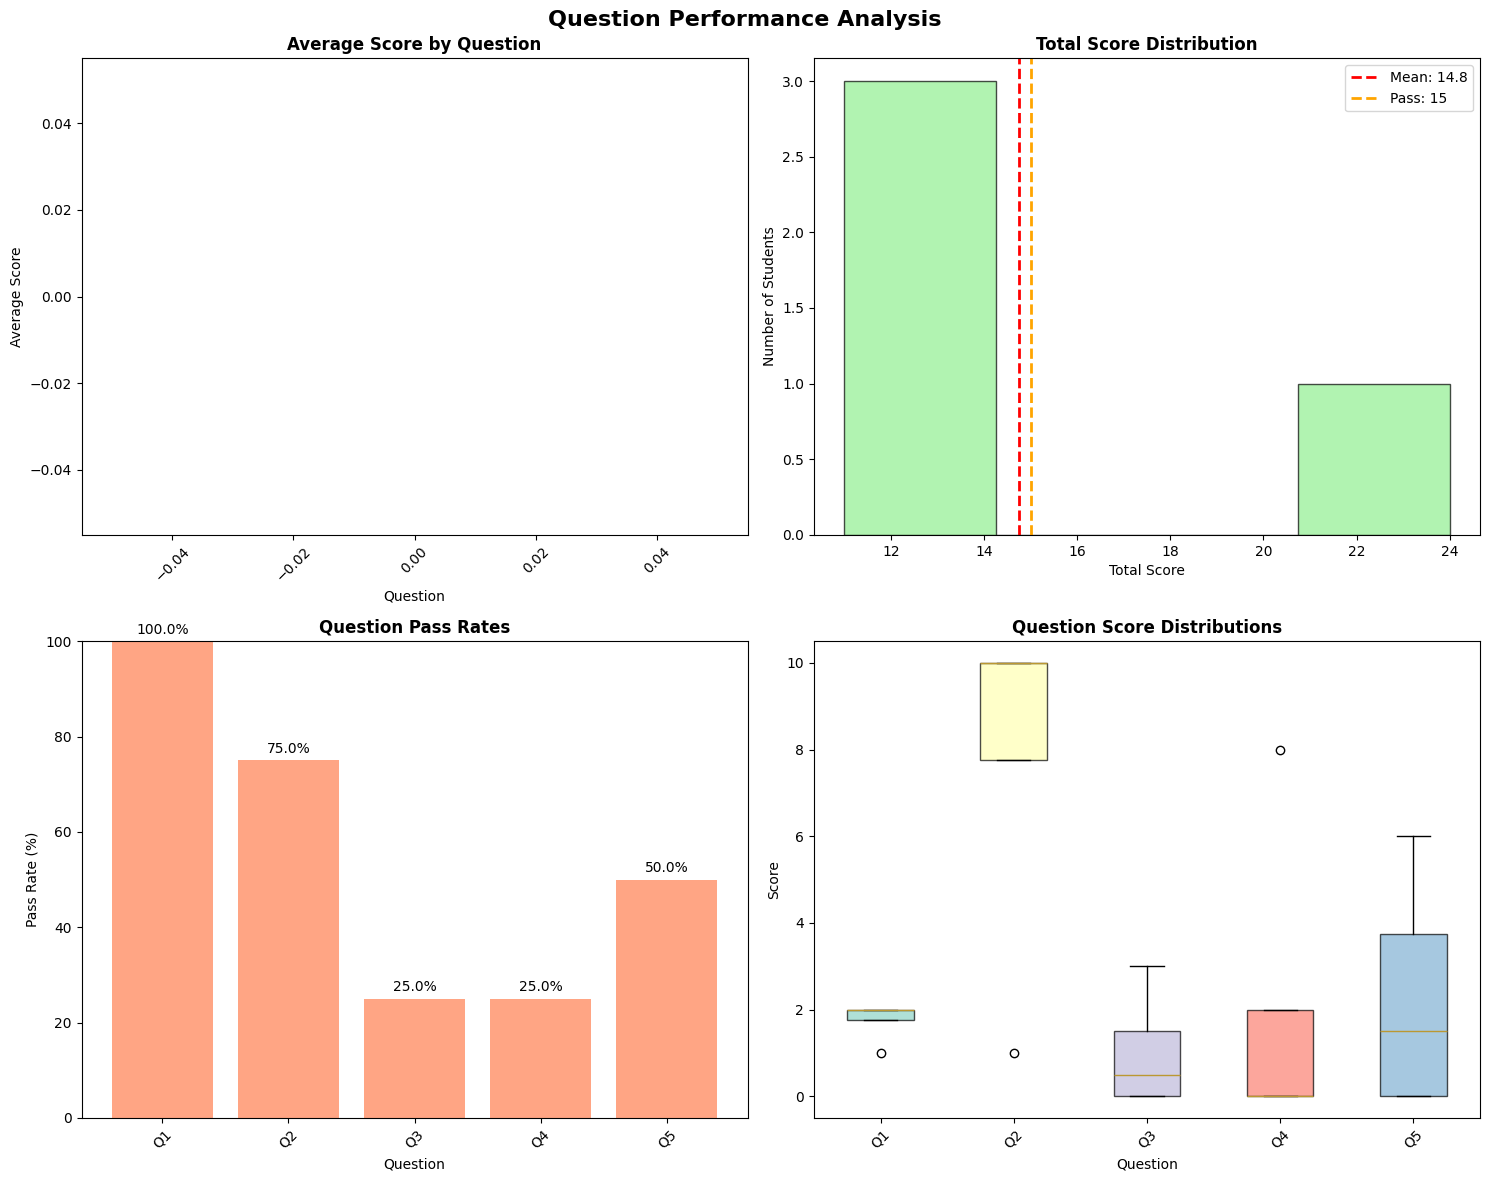

2026-01-04 23:02:55,654 - INFO - ✓ Generated question analysis charts: question_analysis_charts.png
2026-01-04 23:02:55,655 - INFO - ✓ Generated question metrics for 5 questions


📊 Saved QuestionMetrics sheet in: details_score_report.xlsx


,Question,Mean,Median,StdDev,Min,Max,NonNull,Pass Cutoff,Pass Rate (%)
0,Q1,1.75,2.0,0.500000,1.0,2.0,4,1.0,100.0
1,Q2,7.75,10.0,4.500000,1.0,10.0,4,5.0,75.0
2,Q3,1.00,0.5,1.414214,0.0,3.0,4,1.5,25.0
3,Q4,2.00,0.0,4.000000,0.0,8.0,4,4.0,25.0
4,Q5,2.25,1.5,2.872281,0.0,6.0,4,3.0,50.0


/tmp/ipykernel_160185/3601387478.py:108: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax4.boxplot(question_data, labels=question_cols, patch_artist=True)


📊 Generating question-level metrics and visualizations...


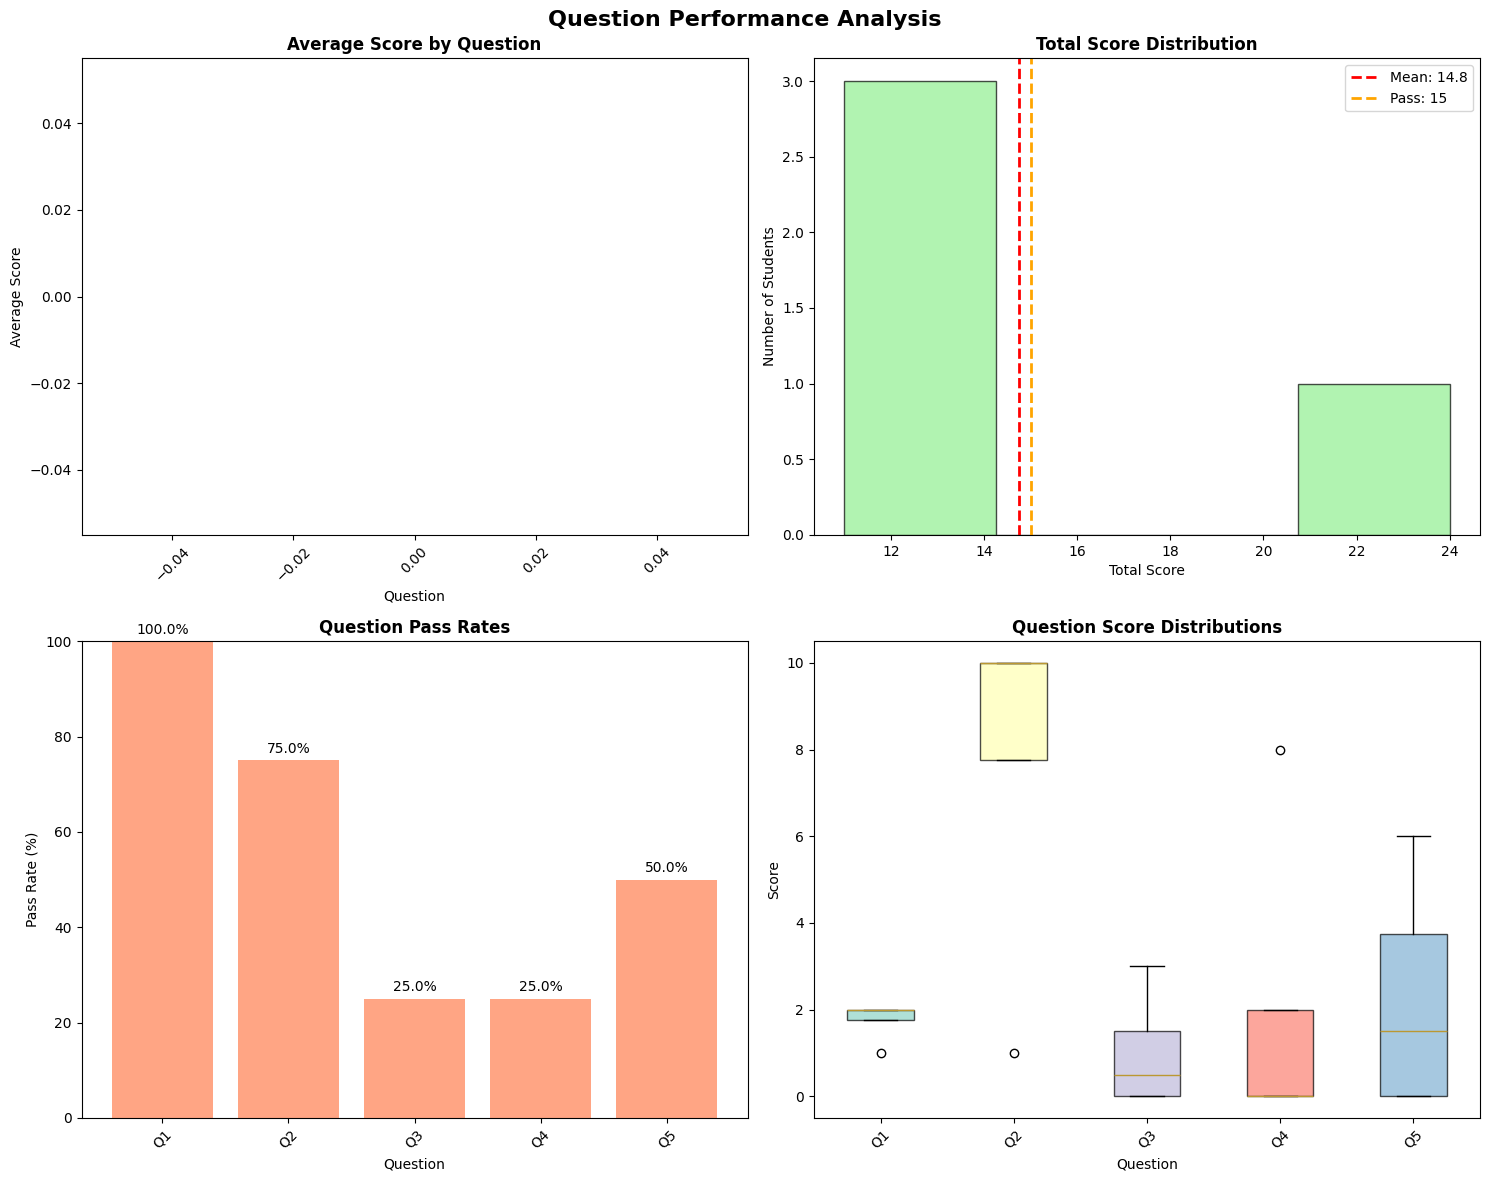

2026-01-04 23:02:56,393 - INFO - ✓ Generated question analysis charts: question_analysis_charts.png
2026-01-04 23:02:56,393 - INFO - ✓ Generated question metrics for 5 questions


📊 Saved QuestionMetrics sheet in: details_score_report.xlsx


,Question,Mean,Median,StdDev,Min,Max,NonNull,Pass Cutoff,Pass Rate (%)
0,Q1,1.75,2.0,0.500000,1.0,2.0,4,1.0,100.0
1,Q2,7.75,10.0,4.500000,1.0,10.0,4,5.0,75.0
2,Q3,1.00,0.5,1.414214,0.0,3.0,4,1.5,25.0
3,Q4,2.00,0.0,4.000000,0.0,8.0,4,4.0,25.0
4,Q5,2.25,1.5,2.872281,0.0,6.0,4,3.0,50.0


In [11]:
# Enhanced Question-Level Metrics and Visualizations
def generate_question_metrics():
    """Generate detailed question-level performance metrics and visualizations"""
    print("📊 Generating question-level metrics and visualizations...")
    
    try:
        # Question columns (excluding metadata)
        question_cols = [c for c in marksDf.columns if c not in ["ID", "NAME", "CLASS", "Marks"] and c not in METADATA_QUESTIONS]
        
        if not question_cols:
            logger.warning("No question columns found for metrics")
            return pd.DataFrame()
        
        # Calculate question-level statistics
        question_stats = []
        passing_cutoff = globals().get("passingMark", 15)
        
        for q in question_cols:
            q_data = marksDf[q].apply(pd.to_numeric, errors='coerce').dropna()
            if len(q_data) == 0:
                continue
                
            # Assume 50% of max score as passing for individual questions
            q_max = q_data.max()
            q_pass_cutoff = q_max * 0.5 if q_max > 0 else 0
            q_pass_count = (q_data >= q_pass_cutoff).sum()
            q_pass_rate = (q_pass_count / len(q_data) * 100) if len(q_data) > 0 else 0
            
            question_stats.append({
                "Question": q,
                "Mean": round(q_data.mean(), 2),
                "Median": round(q_data.median(), 2),
                "StdDev": round(q_data.std(), 6),
                "Min": round(q_data.min(), 2),
                "Max": round(q_data.max(), 2),
                "NonNull": len(q_data),
                "Pass Cutoff": round(q_pass_cutoff, 2),
                "Pass Rate (%)": round(q_pass_rate, 1)
            })
        
        question_metrics_df = pd.DataFrame(question_stats)
        
        # Save question metrics to Excel
        with pd.ExcelWriter(
            details_report_path,
            mode="a" if os.path.exists(details_report_path) else "w",
            engine="openpyxl" if os.path.exists(details_report_path) else None,
            if_sheet_exists="replace" if os.path.exists(details_report_path) else None,
        ) as writer:
            question_metrics_df.to_excel(writer, sheet_name="QuestionMetrics", index=False)

        # Generate visualizations
        if len(question_cols) > 0:
            try:
                # Set up the plotting style
                plt.style.use('default')
                sns.set_palette("husl")
                
                # Create subplots for different visualizations
                fig, axes = plt.subplots(2, 2, figsize=(15, 12))
                fig.suptitle('Question Performance Analysis', fontsize=16, fontweight='bold')
                
                # 1. Question means bar chart
                ax1 = axes[0, 0]
                question_means = marksDf[question_cols].mean(numeric_only=True)
                bars1 = ax1.bar(question_means.index, question_means.values, color='skyblue', alpha=0.7)
                ax1.set_title('Average Score by Question', fontweight='bold')
                ax1.set_xlabel('Question')
                ax1.set_ylabel('Average Score')
                ax1.tick_params(axis='x', rotation=45)
                
                # Add value labels on bars
                for bar in bars1:
                    height = bar.get_height()
                    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                            f'{height:.1f}', ha='center', va='bottom')
                
                # 2. Score distribution histogram
                ax2 = axes[0, 1]
                ax2.hist(marksDf['Marks'], bins=min(10, len(marksDf)), color='lightgreen', alpha=0.7, edgecolor='black')
                ax2.axvline(marksDf['Marks'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {marksDf["Marks"].mean():.1f}')
                ax2.axvline(passing_cutoff, color='orange', linestyle='--', linewidth=2, label=f'Pass: {passing_cutoff}')
                ax2.set_title('Total Score Distribution', fontweight='bold')
                ax2.set_xlabel('Total Score')
                ax2.set_ylabel('Number of Students')
                ax2.legend()
                
                # 3. Question difficulty (pass rates)
                ax3 = axes[1, 0]
                if not question_metrics_df.empty:
                    bars3 = ax3.bar(question_metrics_df['Question'], question_metrics_df['Pass Rate (%)'], 
                                   color='coral', alpha=0.7)
                    ax3.set_title('Question Pass Rates', fontweight='bold')
                    ax3.set_xlabel('Question')
                    ax3.set_ylabel('Pass Rate (%)')
                    ax3.tick_params(axis='x', rotation=45)
                    ax3.set_ylim(0, 100)
                    
                    # Add value labels on bars
                    for bar in bars3:
                        height = bar.get_height()
                        ax3.text(bar.get_x() + bar.get_width()/2., height + 1,
                                f'{height:.1f}%', ha='center', va='bottom')
                
                # 4. Question score ranges (box plot)
                ax4 = axes[1, 1]
                question_data = [marksDf[col].apply(pd.to_numeric, errors='coerce').dropna() for col in question_cols]
                bp = ax4.boxplot(question_data, labels=question_cols, patch_artist=True)
                ax4.set_title('Question Score Distributions', fontweight='bold')
                ax4.set_xlabel('Question')
                ax4.set_ylabel('Score')
                ax4.tick_params(axis='x', rotation=45)
                
                # Color the box plots
                colors = plt.cm.Set3(range(len(bp['boxes'])))
                for patch, color in zip(bp['boxes'], colors):
                    patch.set_facecolor(color)
                    patch.set_alpha(0.7)
                
                plt.tight_layout()
                
                # Save the plot
                chart_path = base_path_marked_scripts + "question_analysis_charts.png"
                plt.savefig(chart_path, dpi=300, bbox_inches='tight')
                plt.show()
                
                logger.info(f"✓ Generated question analysis charts: {os.path.basename(chart_path)}")
                
            except Exception as e:
                logger.warning(f"Failed to generate visualizations: {e}")
        
        logger.info(f"✓ Generated question metrics for {len(question_cols)} questions")
        print(f"📊 Saved QuestionMetrics sheet in: {os.path.basename(details_report_path)}")
        
        return question_metrics_df
        
    except Exception as e:
        logger.error(f"❌ Question metrics generation failed: {e}")
        return pd.DataFrame()

# Generate question metrics and visualizations
question_metrics_df = generate_question_metrics()
if not question_metrics_df.empty:
    display(question_metrics_df)

# Generate question metrics and visualizations
question_metrics_df = generate_question_metrics()
if not question_metrics_df.empty:
    display(question_metrics_df)

In [12]:
# Enhanced Word Document Report Generation
def generate_word_report():
    """Generate comprehensive Word document report with charts and analytics"""
    print("📄 Generating comprehensive Word document report...")
    
    try:
        from docx import Document
        from docx.enum.text import WD_ALIGN_PARAGRAPH
        from docx.shared import Pt, Inches
        import re
        import os
        
        # Ensure required data is available
        if 'class_overview_df' not in globals() or class_overview_df.empty:
            logger.warning("Class overview data not available, generating basic report")
            return None
        
        # Create charts directory
        charts_dir = os.path.join(base_path_marked_scripts, "charts")
        os.makedirs(charts_dir, exist_ok=True)
        
        # Initialize Word document
        word_path = os.path.join(base_path_marked_scripts, "class_overview_report.docx")
        doc = Document()
        
        # Base styles
        doc.styles["Normal"].font.size = Pt(11)
        
        # Document title
        title_text = "Class Performance Overview"
        if "prefix" in globals() and prefix:
            title_text = f"{prefix} - {title_text}"
        doc.add_heading(title_text, level=1)
        
        # Key stats summary
        total_students = len(marksDf)
        avg_score = marksDf['Marks'].mean()
        median_score = marksDf['Marks'].median()
        pass_count = len(marksDf[marksDf['Marks'] > passingMark])
        pass_rate = (pass_count / total_students * 100) if total_students > 0 else 0
        
        summary_line = (
            f"Students: {total_students} | Mean: {avg_score:.2f} | Median: {median_score:.2f} | "
            f"Pass rate: {pass_rate:.1f}% (cutoff {passingMark})"
        )
        doc.add_paragraph(summary_line)
        
        def add_markdown_line(md_line, bullet=False, heading_level=None):
            """Render a single markdown line into the docx with bold/italic support."""
            if heading_level:
                p = doc.add_heading(level=heading_level)
            elif bullet:
                p = doc.add_paragraph(style="List Bullet")
            else:
                p = doc.add_paragraph()

            tokens = re.split(r"(\*\*[^*]+\*\*|__[^_]+__|\*[^*]+\*|_[^_]+_)", md_line)
            for tok in tokens:
                if not tok:
                    continue
                bold = tok.startswith("**") or tok.startswith("__")
                italic = tok.startswith("*") or tok.startswith("_")
                clean = tok.strip("*_ ")
                run = p.add_run(clean)
                if bold:
                    run.bold = True
                if italic:
                    run.italic = True
            return p
        
        # Add Gemini narrative if available
        if 'class_overview_df' in globals():
            gemini_overview = class_overview_df[class_overview_df['Metric'] == 'Gemini Class Overview']
            if not gemini_overview.empty:
                class_overview_report = gemini_overview.iloc[0]['Value']
                if class_overview_report and str(class_overview_report) != 'nan':
                    doc.add_heading("AI-Generated Class Analysis", level=2)
                    for raw_line in str(class_overview_report).splitlines():
                        line = raw_line.rstrip()
                        if not line:
                            continue
                        heading_match = re.match(r"^(#{1,3})\s+(.*)$", line)
                        if heading_match:
                            level = len(heading_match.group(1))
                            add_markdown_line(heading_match.group(2), heading_level=level)
                            continue
                        if re.match(r"^[-*+]\s+", line):
                            add_markdown_line(line[2:].strip(), bullet=True)
                            continue
                        num_match = re.match(r"^\d+\.\s+(.*)$", line)
                        if num_match:
                            p = add_markdown_line(num_match.group(1))
                            p.style = "List Number"
                            continue
                        p = add_markdown_line(line)
                        p.alignment = WD_ALIGN_PARAGRAPH.LEFT
        
        # Generate and add class-level charts
        try:
            overall_hist = os.path.join(charts_dir, "overall_hist.png")
            pass_bar = os.path.join(charts_dir, "pass_bar.png")
            
            # Score distribution histogram
            plt.figure(figsize=(8, 4))
            plt.hist(pd.to_numeric(marksDf["Marks"], errors="coerce").dropna(), bins=20, color="#4a90e2", alpha=0.7, edgecolor='black')
            plt.xlabel("Total Score")
            plt.ylabel("Number of Students")
            plt.title("Score Distribution (Class)")
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig(overall_hist, dpi=180, bbox_inches='tight')
            plt.close()
            
            # Pass/Fail bar chart
            plt.figure(figsize=(6, 4))
            fail_count = total_students - pass_count
            plt.bar(["Pass", "Fail"], [pass_count, fail_count], color=["#4caf50", "#e74c3c"], alpha=0.7)
            plt.ylabel("Number of Students")
            plt.title("Pass / Fail Distribution")
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig(pass_bar, dpi=180, bbox_inches='tight')
            plt.close()
            
            # Add charts to document
            doc.add_page_break()
            doc.add_heading("Class Performance Charts", level=2)
            doc.add_paragraph("Score histogram shows the distribution of total scores across all students.")
            doc.add_picture(overall_hist, width=Inches(6))
            doc.add_paragraph("Pass/Fail distribution shows how many students met the passing criteria.")
            doc.add_picture(pass_bar, width=Inches(4))
            
        except Exception as e:
            logger.warning(f"Failed to generate class charts: {e}")
        
        # Add metrics table
        if 'class_overview_df' in globals() and not class_overview_df.empty:
            table_df = class_overview_df.copy()
            # Exclude the Gemini overview from the metrics table
            table_df = table_df[table_df["Metric"] != "Gemini Class Overview"]
            
            if not table_df.empty:
                doc.add_page_break()
                doc.add_heading("Performance Metrics", level=2)
                table = doc.add_table(rows=1, cols=2, style="Light Grid")
                hdr_cells = table.rows[0].cells
                hdr_cells[0].text = "Metric"
                hdr_cells[1].text = "Value"
                
                for _, row in table_df.iterrows():
                    cells = table.add_row().cells
                    cells[0].text = str(row["Metric"])
                    cells[1].text = str(row["Value"])
        
        # Add per-question metrics if available
        if 'question_metrics_df' in globals() and not question_metrics_df.empty:
            doc.add_page_break()
            doc.add_heading("Per-Question Analysis", level=2)
            
            # Create question metrics table
            pq_table = doc.add_table(rows=1, cols=6, style="Light Grid")
            hdr = pq_table.rows[0].cells
            hdr[0].text = "Question"
            hdr[1].text = "Mean"
            hdr[2].text = "Median"
            hdr[3].text = "StdDev"
            hdr[4].text = "Min / Max"
            hdr[5].text = "Pass Rate (%)"
            
            for _, r in question_metrics_df.iterrows():
                cells = pq_table.add_row().cells
                cells[0].text = str(r.get("Question", ""))
                cells[1].text = f"{r['Mean']:.2f}" if pd.notna(r.get("Mean")) else ""
                cells[2].text = f"{r['Median']:.2f}" if pd.notna(r.get("Median")) else ""
                cells[3].text = f"{r['StdDev']:.2f}" if pd.notna(r.get("StdDev")) else ""
                min_val = f"{r['Min']:.2f}" if pd.notna(r.get("Min")) else ""
                max_val = f"{r['Max']:.2f}" if pd.notna(r.get("Max")) else ""
                cells[4].text = f"{min_val} / {max_val}" if (min_val or max_val) else ""
                cells[5].text = f"{r['Pass Rate (%)']:.1f}" if pd.notna(r.get("Pass Rate (%)")) else ""
            
            # Generate and add question-level charts
            try:
                mean_chart = os.path.join(charts_dir, "question_mean.png")
                box_chart = os.path.join(charts_dir, "question_box.png")
                pass_rate_chart = os.path.join(charts_dir, "question_pass_rate.png")
                
                # Question means with error bars
                plt.figure(figsize=(10, 5))
                plt.bar(question_metrics_df["Question"], question_metrics_df["Mean"], 
                       yerr=question_metrics_df["StdDev"], capsize=4, alpha=0.7, color='skyblue')
                plt.ylabel("Mean Score")
                plt.title("Mean Score per Question")
                plt.xticks(rotation=45)
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.savefig(mean_chart, dpi=180, bbox_inches='tight')
                plt.close()
                
                # Box plots for score distributions
                question_cols = [c for c in marksDf.columns if c not in ["ID", "NAME", "CLASS", "Marks"] and c not in METADATA_QUESTIONS]
                if question_cols:
                    plt.figure(figsize=(10, 5))
                    box_data = [pd.to_numeric(marksDf[q], errors="coerce").dropna() for q in question_cols]
                    plt.boxplot(box_data, labels=question_cols)
                    plt.ylabel("Score")
                    plt.title("Score Distribution per Question")
                    plt.xticks(rotation=45)
                    plt.grid(True, alpha=0.3)
                    plt.tight_layout()
                    plt.savefig(box_chart, dpi=180, bbox_inches='tight')
                    plt.close()
                
                # Pass rate chart
                plt.figure(figsize=(10, 5))
                plt.bar(question_metrics_df["Question"], question_metrics_df["Pass Rate (%)"], 
                       color="#7b7ce6", alpha=0.7)
                plt.ylabel("Pass Rate (%)")
                plt.title("Pass Rate per Question")
                plt.xticks(rotation=45)
                plt.ylim(0, 100)
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.savefig(pass_rate_chart, dpi=180, bbox_inches='tight')
                plt.close()
                
                # Add charts to document
                doc.add_paragraph("Mean score bars show average performance per question, with error bars indicating variability.")
                doc.add_picture(mean_chart, width=Inches(6))
                
                if question_cols:
                    doc.add_paragraph("Box plots show the distribution of scores for each question (median, quartiles, and outliers).")
                    doc.add_picture(box_chart, width=Inches(6))
                
                doc.add_paragraph("Pass rate bars show the percentage of students who achieved at least half marks for each question.")
                doc.add_picture(pass_rate_chart, width=Inches(6))
                
            except Exception as e:
                logger.warning(f"Failed to generate question charts: {e}")
        
        # Add strengths and focus areas
        if 'class_overview_df' in globals():
            strengths_row = class_overview_df[class_overview_df['Metric'] == 'Top Strength Questions']
            focus_row = class_overview_df[class_overview_df['Metric'] == 'Top Focus Questions']
            
            if not strengths_row.empty and str(strengths_row.iloc[0]['Value']) != '':
                doc.add_heading("Top Strength Questions", level=2)
                strengths_text = str(strengths_row.iloc[0]['Value'])
                for item in strengths_text.split(', '):
                    if item.strip():
                        doc.add_paragraph(item.strip(), style="List Bullet")
            
            if not focus_row.empty and str(focus_row.iloc[0]['Value']) != '':
                doc.add_heading("Areas Needing Focus", level=2)
                focus_text = str(focus_row.iloc[0]['Value'])
                for item in focus_text.split(', '):
                    if item.strip():
                        doc.add_paragraph(item.strip(), style="List Bullet")
        
        # Add footer with generation info
        footer = doc.add_paragraph()
        footer_run = footer.add_run(f"Report generated on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')} | Enhanced Step 6 Processing")
        footer_run.font.size = Pt(9)
        footer.alignment = WD_ALIGN_PARAGRAPH.CENTER
        
        # Save the document
        doc.save(word_path)
        logger.info(f"✓ Generated Word report: {os.path.basename(word_path)}")
        print(f"📄 Saved Word report: {word_path}")
        
        return word_path
        
    except Exception as e:
        logger.error(f"❌ Word report generation failed: {e}")
        return None

# Generate Word document report
word_report_path = generate_word_report()
if word_report_path:
    print(f"✅ Word document report generated successfully!")
    print(f"📁 Location: {word_report_path}")
else:
    print("⚠️ Word document generation was skipped due to missing data or errors")

📄 Generating comprehensive Word document report...


/tmp/ipykernel_160185/3730686946.py:204: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=question_cols)
2026-01-04 23:02:56,878 - INFO - ✓ Generated Word report: class_overview_report.docx


📄 Saved Word report: ../marking_form/VTC Test/marked/scripts/class_overview_report.docx
✅ Word document report generated successfully!
📁 Location: ../marking_form/VTC Test/marked/scripts/class_overview_report.docx


In [13]:
# Enhanced final summary and next steps
def generate_final_summary():
    """Generate comprehensive final summary with actionable next steps"""
    
    print("\n" + "="*70)
    print("🎉 ENHANCED STEP 6: POST-SCORING PACKAGING COMPLETE")
    print("="*70)
    
    # Overall statistics
    total_students = len(marksDf)
    avg_score = marksDf['Marks'].mean()
    passing_students = len(marksDf[marksDf['Marks'] > passingMark])
    pass_rate = (passing_students / total_students * 100) if total_students > 0 else 0
    
    print(f"\n📊 Processing Results:")
    print(f"   Total students processed: {total_students}")
    print(f"   Average score: {avg_score:.2f}")
    print(f"   Passing students: {passing_students} ({pass_rate:.1f}%)")
    print(f"   Score range: {marksDf['Marks'].min():.1f} - {marksDf['Marks'].max():.1f}")
    
    print(f"\n📁 Generated Files:")
    print(f"   ✅ Backup archive: {os.path.basename(backup_path)}")
    print(f"   ✅ Individual PDFs: {pdf_stats['successful']} created")
    print(f"   ✅ Combined PDF: all.pdf")
    print(f"   ✅ Sample collections: Multiple stratified samples")
    print(f"   ✅ Comprehensive Excel reports with multiple sheets:")
    print(f"      • Marks, Answers, Reasoning (wide format)")
    print(f"      • Raw data for audit trail")
    print(f"      • AI-powered Performance reports")
    print(f"      • Class-level analytics and overview")
    print(f"      • Question-level metrics and statistics")
    print(f"   ✅ Visual analytics: Question performance charts")
    
    if pdf_stats['failed'] > 0:
        print(f"   ⚠️ PDF generation issues: {pdf_stats['failed']} failed")
    
    if failed_students:
        print(f"   ⚠️ Student processing issues: {len(failed_students)} students")
    
    print(f"\n🤖 AI-Enhanced Features:")
    if not performance_df.empty:
        print(f"   ✅ Individual performance reports: {len(performance_df)} generated")
    if not class_overview_df.empty:
        print(f"   ✅ Class-level analytics with AI insights")
    print(f"   ✅ Metadata questions properly excluded from analysis")
    print(f"   ✅ Comprehensive caching for efficient re-runs")
    
    print(f"\n🎯 Next Steps:")
    print(f"   1. 📧 Proceed to Step 7: Email Score Distribution")
    print(f"   2. 📊 Review detailed analytics in Excel reports")
    print(f"   3. 📄 Use sample PDFs for moderation and review")
    print(f"   4. 🤖 Review AI-generated performance insights")
    print(f"   5. 📈 Analyze question-level metrics for curriculum improvement")
    print(f"   6. 💾 Archive backup file for long-term storage")
    
    print(f"\n💡 Enhanced Quality Assurance:")
    print(f"   • All processing includes comprehensive validation")
    print(f"   • Error handling ensures partial failures don't stop processing")
    print(f"   • Detailed logging provides full audit trail")
    print(f"   • Multiple output formats support different use cases")
    print(f"   • AI-powered insights provide actionable feedback")
    print(f"   • Metadata questions properly handled and excluded")
    print(f"   • Visual analytics support data-driven decisions")
    
    print("\n" + "="*70)
    print(f"✅ Enhanced Step 6 completed successfully at {datetime.now().strftime('%H:%M:%S')}")
    print("🚀 Ready for final distribution, analysis, and archival!")
    print("="*70)

# Generate final comprehensive summary
generate_final_summary()


🎉 ENHANCED STEP 6: POST-SCORING PACKAGING COMPLETE

📊 Processing Results:
   Total students processed: 4
   Average score: 14.75
   Passing students: 1 (25.0%)
   Score range: 11.0 - 24.0

📁 Generated Files:
   ✅ Backup archive: VTC Test.zip
   ✅ Individual PDFs: 4 created
   ✅ Combined PDF: all.pdf
   ✅ Sample collections: Multiple stratified samples
   ✅ Comprehensive Excel reports with multiple sheets:
      • Marks, Answers, Reasoning (wide format)
      • Raw data for audit trail
      • AI-powered Performance reports
      • Class-level analytics and overview
      • Question-level metrics and statistics
   ✅ Visual analytics: Question performance charts

🤖 AI-Enhanced Features:
   ✅ Individual performance reports: 4 generated
   ✅ Class-level analytics with AI insights
   ✅ Metadata questions properly excluded from analysis
   ✅ Comprehensive caching for efficient re-runs

🎯 Next Steps:
   1. 📧 Proceed to Step 7: Email Score Distribution
   2. 📊 Review detailed analytics in Exc